# Sinogram Analysis

In [1]:
from prompt_toolkit.utils import to_float
from skimage.transform import iradon
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# Expects all arrays to be of the same length, this comes automatically from the PET lab collection
def readData(directory):
    angle_pattern = re.compile(r"(-?\d+_\d+)\s*Deg")
    angle_to_counts = {}
    distances_ref = []
    for fname in os.listdir(directory):
        if not fname.endswith(".dat"):
            continue
        # print(fname)

        match = angle_pattern.search(fname)
        if not match:
            raise ValueError(f"Angle not found in filename: {fname}")

        angle = float(match.group(1).replace("_", "."))

        data = pd.read_csv(
            os.path.join(directory, fname),
            sep=r"\s+",
            skiprows=1,
            names=["Distance", "Counts"]
        )
        # print(distances_ref)
        # if distances_ref is None:
        if (np.size(distances_ref) == 0):
            distances_ref = data["Distance"].to_numpy()
        elif (not (distances_ref == data["Distance"].to_numpy()).all()):
            raise ValueError("Distance grid mismatch in file: " + fname)
        # print(distances_ref)

        angle_to_counts[angle] = data["Counts"].to_numpy()

    angles = np.array(sorted(angle_to_counts.keys()))
    # print(angles)
    # Build 2D array: rows = distance, cols = angle
    counts_2d = np.column_stack([angle_to_counts[a] for a in angles])
    
    midpoint = (distances_ref[-1] - distances_ref[0])/2
    distances_ref = distances_ref - midpoint
    # print(distances_ref)
    return counts_2d, distances_ref, angles

def display_raw_sinogram(count, distance, angle, savename):
    plt.figure()
    plt.imshow(
        count,
        origin="lower",
        aspect="auto",
        extent=[
            angle[0], angle[-1],
            distance[0], distance[-1]],
        cmap="gray"
    )
    plt.title("Raw Sinogram")
    plt.xlabel("Angle (deg)")
    plt.ylabel("Distance (mm)")
    plt.colorbar(label="Counts")
    plt.savefig(savename)
    plt.show()
    return

def display_reconstructed_image(recon, distance, savename):
    plt.figure()
    plt.imshow(recon, extent=[
        distance[0], distance[-1],
        distance[0], distance[-1]],
               cmap="gray", origin="lower")
    plt.colorbar(label="Reconstructed intensity")
    plt.title("Backprojection reconstruction")
    plt.ylabel("Distance (mm)")
    plt.xlabel("Distance (mm)")
    plt.savefig(savename)
    plt.show()
    return


In [6]:

directory = "./data/Preliminary Scan - 2026-01-09"
countArr, distance, angles = readData(directory)


In [3]:
print(distance)

NameError: name 'distance' is not defined

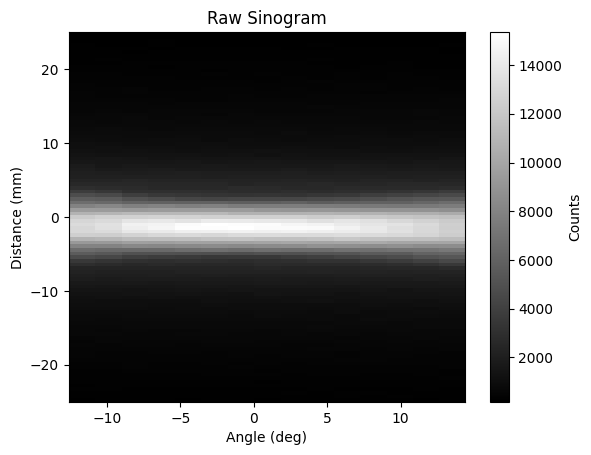

In [7]:
angles = angles + 14.4
display_raw_sinogram(countArr, distance, angles, "prelim scan sinogram")

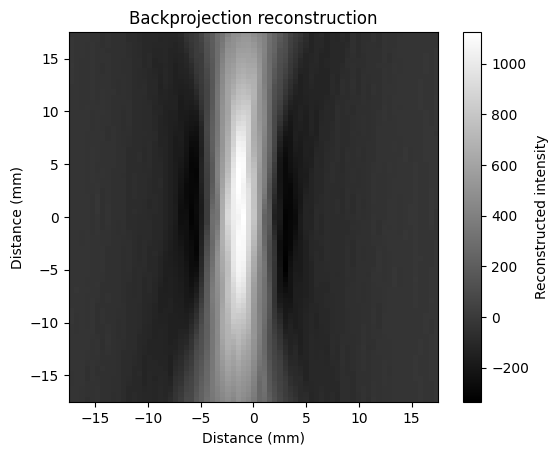

In [8]:

recon = iradon( countArr, theta=angles, filter_name="ramp", circle=False)
dimx, dimy = recon.shape
step_size = distance[1] - distance[0] # I know that step size is constant
half_width = (dimx - 1) * step_size / 2

recon_distance = np.linspace(-half_width, half_width, dimx)

display_reconstructed_image(recon, recon_distance, "prelim scan reconstruction")
# plt.figure()
# plt.imshow(recon, cmap="gray_r", origin="lower")
# plt.colorbar(label="Reconstructed intensity")
# plt.title("Backprojection reconstruction")
# plt.ylabel("Distance (mm)")
# plt.xlabel("Distance (mm)")
# plt.show()

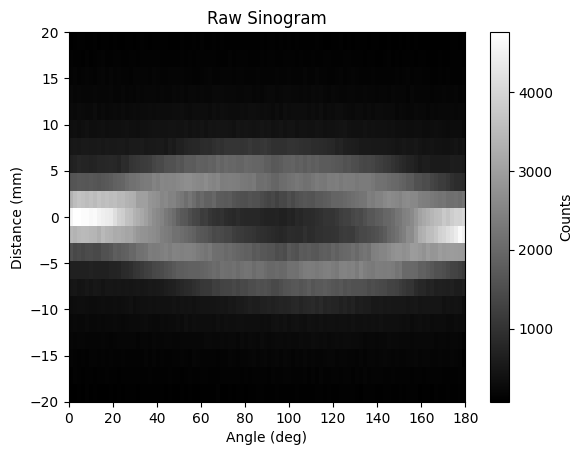

(21, 100)
(29, 29)
58.0
[-2.90000000e+01 -2.69285714e+01 -2.48571429e+01 -2.27857143e+01
 -2.07142857e+01 -1.86428571e+01 -1.65714286e+01 -1.45000000e+01
 -1.24285714e+01 -1.03571429e+01 -8.28571429e+00 -6.21428571e+00
 -4.14285714e+00 -2.07142857e+00  3.55271368e-15  2.07142857e+00
  4.14285714e+00  6.21428571e+00  8.28571429e+00  1.03571429e+01
  1.24285714e+01  1.45000000e+01  1.65714286e+01  1.86428571e+01
  2.07142857e+01  2.27857143e+01  2.48571429e+01  2.69285714e+01
  2.90000000e+01]


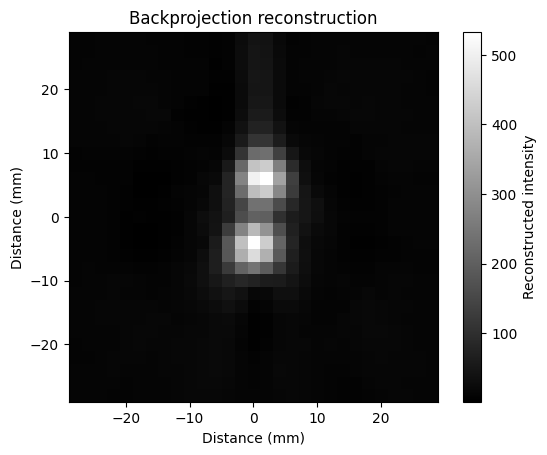

In [40]:
directory = "./data/Measurement Run 1 01-14-2026"
countArr, distance, angles = readData(directory)
angles = angles + 180
# print(distance)
display_raw_sinogram(countArr, distance, angles, "measurement 1 sinogram")
print(countArr.shape)
recon = iradon(countArr, theta=angles, output_size=int(len(distance) * np.sqrt(2)), filter_name="cosine",  circle=False)

dimx, dimy = recon.shape # dims are the same since it has to be square
print(recon.shape)
total_physical_width = dimx * (distance[1]- distance[0])
print(total_physical_width)
half_width = total_physical_width / 2
recon_distance = np.linspace(-half_width, half_width, dimx)
print(recon_distance)

display_reconstructed_image(recon, recon_distance, "measurement 1 reconstruction")

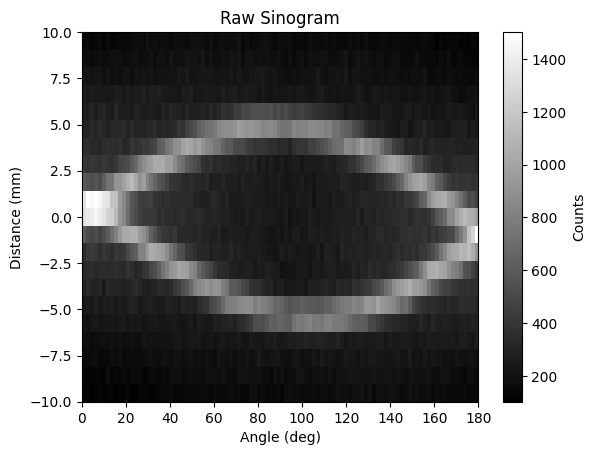

(21, 100)
(29, 29)
29.0
[-1.45000000e+01 -1.34642857e+01 -1.24285714e+01 -1.13928571e+01
 -1.03571429e+01 -9.32142857e+00 -8.28571429e+00 -7.25000000e+00
 -6.21428571e+00 -5.17857143e+00 -4.14285714e+00 -3.10714286e+00
 -2.07142857e+00 -1.03571429e+00  1.77635684e-15  1.03571429e+00
  2.07142857e+00  3.10714286e+00  4.14285714e+00  5.17857143e+00
  6.21428571e+00  7.25000000e+00  8.28571429e+00  9.32142857e+00
  1.03571429e+01  1.13928571e+01  1.24285714e+01  1.34642857e+01
  1.45000000e+01]


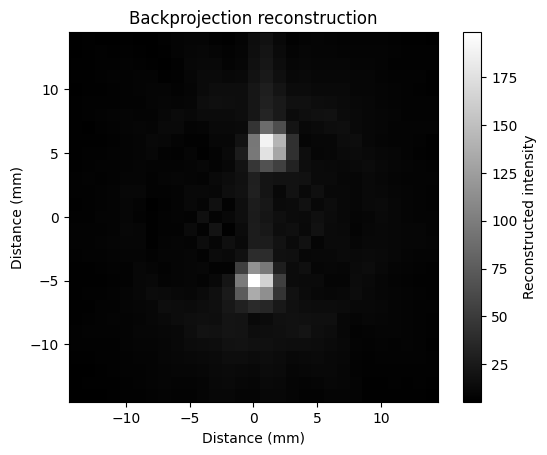

In [41]:
directory = "./data/Measurement Run 3 01-16-2026"
countArr, distance, angles = readData(directory)
# print(distance)
angles = angles + 180
display_raw_sinogram(countArr, distance, angles, "measurement 3 sinogram")
print(countArr.shape)
recon = iradon(countArr, theta=angles, output_size=int(len(distance) * np.sqrt(2)), filter_name="cosine", circle=False)

dimx, dimy = recon.shape # dims are the same since it has to be square
print(recon.shape)
total_physical_width = dimx * (distance[1]- distance[0])
print(total_physical_width)
half_width = total_physical_width / 2
recon_distance = np.linspace(-half_width, half_width, dimx)
print(recon_distance)

# print(dimx)
# step_size = distance[1] - distance[0] # I know that step size is constant
# half_width = (dimx - 1) * step_size / 2
#
# recon_distance = np.linspace(-dimx, dimx,  int(float(dimx * 2 )/float(step_size)))
# print(recon_distance)

display_reconstructed_image(recon, recon_distance, "measurement 3 reconstruction")